# Group Project (Education Level)

In [177]:
%%time
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats 
from pingouin import pairwise_tests #this is for performing the pairwise tests
from pingouin import pairwise_ttests #this is for performing the pairwise tests
from sklearn.feature_extraction.text import CountVectorizer
from datetime import datetime
import gzip
import json
import string


Wall time: 996 µs


## Loading the data

We plan to use the data taken from the 2020 US Census to tell us about the education levels of each state. We hypothesize that parents in highly educated states may demand that their children achieve a higher level of education, which may result in more engagement throughout online educational platforms. We got the data from data.census.gov which was collected by the U.S. Department of Commerce, and it is highly descriptive and informative. 

In [159]:
edu_level = pd.read_csv("./Digital Learning/education_level.csv")

print(edu_level.columns)
print(edu_level.info())
edu_level.head()

Index(['Label (Grouping)', 'Alabama!!Total!!Estimate',
       'Alabama!!Percent!!Estimate', 'Alabama!!Male!!Estimate',
       'Alabama!!Percent Male!!Estimate', 'Alabama!!Female!!Estimate',
       'Alabama!!Percent Female!!Estimate', 'Alaska!!Total!!Estimate',
       'Alaska!!Percent!!Estimate', 'Alaska!!Male!!Estimate',
       ...
       'Wyoming!!Male!!Estimate', 'Wyoming!!Percent Male!!Estimate',
       'Wyoming!!Female!!Estimate', 'Wyoming!!Percent Female!!Estimate',
       'Puerto Rico!!Total!!Estimate', 'Puerto Rico!!Percent!!Estimate',
       'Puerto Rico!!Male!!Estimate', 'Puerto Rico!!Percent Male!!Estimate',
       'Puerto Rico!!Female!!Estimate',
       'Puerto Rico!!Percent Female!!Estimate'],
      dtype='object', length=313)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69 entries, 0 to 68
Columns: 313 entries, Label (Grouping) to Puerto Rico!!Percent Female!!Estimate
dtypes: object(313)
memory usage: 168.9+ KB
None


,Label (Grouping),Alabama!!Total!!Estimate,Alabama!!Percent!!Estimate,Alabama!!Male!!Estimate,Alabama!!Percent Male!!Estimate,Alabama!!Female!!Estimate,Alabama!!Percent Female!!Estimate,Alaska!!Total!!Estimate,Alaska!!Percent!!Estimate,Alaska!!Male!!Estimate,...,Wyoming!!Male!!Estimate,Wyoming!!Percent Male!!Estimate,Wyoming!!Female!!Estimate,Wyoming!!Percent Female!!Estimate,Puerto Rico!!Total!!Estimate,Puerto Rico!!Percent!!Estimate,Puerto Rico!!Male!!Estimate,Puerto Rico!!Percent Male!!Estimate,Puerto Rico!!Female!!Estimate,Puerto Rico!!Percent Female!!Estimate
0,AGE BY EDUCATIONAL ATTAINMENT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Population 18 to 24 years,"468,727",(X),"232,322",(X),"236,405",(X),"67,493",(X),"39,428",...,"26,623",(X),"25,303",(X),"316,387",(X),"159,616",(X),"156,771",(X)
2,Less than high school graduate,"62,982",13.40%,"35,285",15.20%,"27,697",11.70%,"8,915",13.20%,"6,171",...,"3,432",12.90%,"2,274",9.00%,"22,575",7.10%,"14,065",8.80%,"8,510",5.40%
3,High school graduate (includes equival...,"170,023",36.30%,"92,663",39.90%,"77,360",32.70%,"33,691",49.90%,"19,837",...,"11,566",43.40%,"7,649",30.20%,"86,786",27.40%,"48,471",30.40%,"38,315",24.40%
4,Some college or associate's degree,"193,079",41.20%,"86,872",37.40%,"106,207",44.90%,"22,510",33.40%,"12,604",...,"9,270",34.80%,"12,541",49.60%,"176,214",55.70%,"85,107",53.30%,"91,107",58.10%


## Extracting and cleaning relevant data


The data is split up into many categories and is currently in a `wide` format with many subcategories for each state. We do not require all of that information so we will be reducing and converting it into a `narrow` format with each row corresponding to a state

First, I will clean the columns and rows by making them all lower case and replaceing ! with " " for the convenience of future analysis

In [160]:
# make column names lowercase and replace "!" with " "
edu_level.columns = [col.lower().replace("!!", " ") for col in edu_level.columns]

# make first column the index
edu_level = edu_level.set_index('label (grouping)')

# make row labels lowercase
edu_level.index = map(str.lower, edu_level.index)

edu_level


,alabama total estimate,alabama percent estimate,alabama male estimate,alabama percent male estimate,alabama female estimate,alabama percent female estimate,alaska total estimate,alaska percent estimate,alaska male estimate,alaska percent male estimate,...,wyoming male estimate,wyoming percent male estimate,wyoming female estimate,wyoming percent female estimate,puerto rico total estimate,puerto rico percent estimate,puerto rico male estimate,puerto rico percent male estimate,puerto rico female estimate,puerto rico percent female estimate
age by educational attainment,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
population 18 to 24 years,"468,727",(X),"232,322",(X),"236,405",(X),"67,493",(X),"39,428",(X),...,"26,623",(X),"25,303",(X),"316,387",(X),"159,616",(X),"156,771",(X)
less than high school graduate,"62,982",13.40%,"35,285",15.20%,"27,697",11.70%,"8,915",13.20%,"6,171",15.70%,...,"3,432",12.90%,"2,274",9.00%,"22,575",7.10%,"14,065",8.80%,"8,510",5.40%
high school graduate (includes equivalency),"170,023",36.30%,"92,663",39.90%,"77,360",32.70%,"33,691",49.90%,"19,837",50.30%,...,"11,566",43.40%,"7,649",30.20%,"86,786",27.40%,"48,471",30.40%,"38,315",24.40%
some college or associate's degree,"193,079",41.20%,"86,872",37.40%,"106,207",44.90%,"22,510",33.40%,"12,604",32.00%,...,"9,270",34.80%,"12,541",49.60%,"176,214",55.70%,"85,107",53.30%,"91,107",58.10%
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
less than high school graduate,"25,395",(X),"30,437",(X),"19,307",(X),"31,565",(X),"34,907",(X),...,"37,278",(X),"22,946",(X),"10,893",(X),"12,194",(X),"7,500",(X)
high school graduate (includes equivalency),"31,997",(X),"40,400",(X),"24,996",(X),"39,150",(X),"44,846",(X),...,"45,130",(X),"27,346",(X),"15,567",(X),"16,384",(X),"13,519",(X)
some college or associate's degree,"36,662",(X),"48,234",(X),"30,353",(X),"44,785",(X),"53,253",(X),...,"51,633",(X),"29,286",(X),"17,438",(X),"19,618",(X),"15,743",(X)
bachelor's degree,"52,385",(X),"69,340",(X),"42,797",(X),"60,141",(X),"70,386",(X),...,"62,619",(X),"41,748",(X),"25,550",(X),"30,177",(X),"23,879",(X)


From the dataframe above it is observed that dataframe contains some <strong>NaN</strong> values as well as <strong>(X)</strong> and <strong>N</strong>

<strong>NaN</strong> and <strong>(X)</strong> aren't concerns since they simply represent percentage that can not be calculated and wouldn't affect the analysis. On the other hand, <strong>N</strong> represent the lack of data that might affect the result of the analysis. However, considering that there's only a few <strong>N</strong> in the dataframe, I decided to convert both <strong>(X)</strong> and <strong>N</strong> to     <strong>NaT</strong>

In [161]:
# replace 'N' and '(X)' with NaN
edu_level = edu_level.replace(['N', '(X)'], pd.NaT)

edu_level.head(9)

,alabama total estimate,alabama percent estimate,alabama male estimate,alabama percent male estimate,alabama female estimate,alabama percent female estimate,alaska total estimate,alaska percent estimate,alaska male estimate,alaska percent male estimate,...,wyoming male estimate,wyoming percent male estimate,wyoming female estimate,wyoming percent female estimate,puerto rico total estimate,puerto rico percent estimate,puerto rico male estimate,puerto rico percent male estimate,puerto rico female estimate,puerto rico percent female estimate
age by educational attainment,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
population 18 to 24 years,"468,727",NaT,"232,322",NaT,"236,405",NaT,"67,493",NaT,"39,428",NaT,...,"26,623",NaT,"25,303",NaT,"316,387",NaT,"159,616",NaT,"156,771",NaT
less than high school graduate,"62,982",13.40%,"35,285",15.20%,"27,697",11.70%,"8,915",13.20%,"6,171",15.70%,...,"3,432",12.90%,"2,274",9.00%,"22,575",7.10%,"14,065",8.80%,"8,510",5.40%
high school graduate (includes equivalency),"170,023",36.30%,"92,663",39.90%,"77,360",32.70%,"33,691",49.90%,"19,837",50.30%,...,"11,566",43.40%,"7,649",30.20%,"86,786",27.40%,"48,471",30.40%,"38,315",24.40%
some college or associate's degree,"193,079",41.20%,"86,872",37.40%,"106,207",44.90%,"22,510",33.40%,"12,604",32.00%,...,"9,270",34.80%,"12,541",49.60%,"176,214",55.70%,"85,107",53.30%,"91,107",58.10%
bachelor's degree or higher,"42,643",9.10%,"17,502",7.50%,"25,141",10.60%,"2,377",3.50%,816,2.10%,...,"2,355",8.80%,"2,839",11.20%,"30,812",9.70%,"11,973",7.50%,"18,839",12.00%
college or higher,"235,722",50.30%,"104,374",44.90%,"131,348",55.50%,"24,887",36.90%,"13,420",34.10%,...,"11,625",43.60%,"15,380",60.80%,"207,026",65.40%,"97,080",60.80%,"109,946",70.10%
population 25 years and over,"3,451,208",NaT,"1,643,071",NaT,"1,808,137",NaT,"485,779",NaT,"250,710",NaT,...,"201,494",NaT,"193,854",NaT,"2,401,409",NaT,"1,107,798",NaT,"1,293,611",NaT
less than 9th grade,"127,052",3.70%,"68,626",4.20%,"58,426",3.20%,"10,548",2.20%,"6,519",2.60%,...,"4,148",2.10%,"3,076",1.60%,"309,413",12.90%,"153,282",13.80%,"156,131",12.10%


For the convenience and the interest of time, Excel was used to create a new row naemd "college or higher" which includes number and percentage of population between 18 to 24 who achived education level higher than college. This new row will be used for finding out education level of each state

In [162]:
# make a new date set that only incuded row "college or higher" and column ends with percent estimante
edu_level_college_or_higher = edu_level.iloc[6]

edu_level_college_or_higher = edu_level_college_or_higher.filter(like='percent estimate')

edu_level_college_or_higher = edu_level_college_or_higher.T.to_frame()

# drop "percent estimate" from the index so that it only incudese name of state
new_index = [label.split("percent estimate")[0].strip() for label in edu_level_college_or_higher.index]
edu_level_college_or_higher = edu_level_college_or_higher.rename(index=dict(zip(edu_level_college_or_higher.index, new_index)))

edu_level_college_or_higher

,college or higher
alabama,50.30%
alaska,36.90%
arizona,49.40%
arkansas,48.50%
california,56.30%
colorado,52.50%
connecticut,60.20%
delaware,51.40%
district of columbia,71.40%
florida,52.80%


In [163]:
# split the strings in the index on "percent estimate" and keep only the first part
new_index = [label.split("percent estimate")[0].strip() for label in edu_level_college_or_higher.index]

# create a new DataFrame with updated index and columns
edu_level_college_or_higher = edu_level_college_or_higher.rename(index=dict(zip(edu_level_college_or_higher.index, new_index)))

# name the first column state
edu_level_college_or_higher = edu_level_college_or_higher.reset_index().rename(columns={'index': 'state'})


edu_level_college_or_higher

,state,college or higher
0,alabama,50.30%
1,alaska,36.90%
2,arizona,49.40%
3,arkansas,48.50%
4,california,56.30%
5,colorado,52.50%
6,connecticut,60.20%
7,delaware,51.40%
8,district of columbia,71.40%
9,florida,52.80%


Now, I'm going to take a look at engagement_data, which was given from the case, to find out students' engagement level. First, I will add a new column which contains district_id for future analysis which will calculate education level for each district(state) for seperate csv files in engagement_data folder. 

In [164]:
# Adding district_id column to csv files in engagement data folder

# Path to the engagement_data folder
folder_path = 'Digital Learning/engagement_data'

# Loop through each file in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.csv'):
        file_path = os.path.join(folder_path, filename)
        
        # Read the CSV file into a dataframe
        df = pd.read_csv(file_path)
        
        # Extract the district ID from the filename
        district_id = filename.split('.')[0]
        
        # Add a new column to the dataframe with the district ID
        df['district_id'] = district_id
        
        # Write the modified dataframe back to the CSV file
        df.to_csv(file_path, index=False)


Also, since engagement data is bunch of csv files in a folder, I'm going to append all the csv files into one dataframe for the convenience of the future analysis and calculation.

In [165]:
# Combine all engagement data to one dataframe

# Set the directory path to the folder containing the CSV files
directory = 'Digital Learning/engagement_data'

# Initialize an empty list to hold the DataFrames
df_list = []

# Loop through each CSV file in the directory
for filename in os.listdir(directory):
    if filename.endswith('.csv'):
        # Read the CSV file into a DataFrame
        filepath = os.path.join(directory, filename)
        df = pd.read_csv(filepath)
        
        # Append the DataFrame to the list
        df_list.append(df)

# Concatenate all the DataFrames in the list into a single DataFrame
engagement_data = pd.concat(df_list, ignore_index=True)

Finally, I will calculate engagement index per state by using district_info dataframe. I used district_id column to find out the state.

In [166]:
# Get engagement by state
# Load district information data
district_info = pd.read_csv('./Digital Learning/districts_info.csv')

# Merge engagement and district information data
merged_data = pd.merge(engagement_data, district_info, on='district_id')

# Calculate average engagement level per state
avg_engagement = merged_data.groupby('state')['engagement_index'].mean().reset_index()

# Create new data frame with state and engagement_index columns
engagement_by_state = avg_engagement[['state', 'engagement_index']]

# make state names lower case 
engagement_by_state['state'] = engagement_by_state['state'].str.lower()

engagement_by_state


,state,engagement_index
0,arizona,740.788101
1,california,113.330664
2,connecticut,257.456419
3,district of columbia,261.397662
4,florida,64.088064
5,illinois,200.544588
6,indiana,221.990979
7,massachusetts,217.493218
8,michigan,104.451529
9,minnesota,160.833411


After calculating engagement index, it became clear thet further cleaning is reuired for engagement data as meaningful insight couldn't be be extracted. Also, it shows some critical flaws as engagement index of Arinona is 740 while Washington and texas is only around 75. This indicatese that there could be possible outliers in the enagagement data. Therefore, I decided to take a look at product_info dataframe to see if there's certain product types that contain a lot of outliers.

In [167]:
# Load products_info CSV

product_info = pd.read_csv("./Digital Learning/products_info.csv")

# rename the column
product_info = product_info.rename(columns={"LP ID": "lp_id"})

# make other columns lower case
product_info.columns = product_info.columns.str.lower()

# Merge engagement and district information data
engagement_by_product = pd.merge(engagement_data, product_info, on='lp_id')




In [168]:
product_info["primary essential function"].unique()

array(['LC - Digital Learning Platforms',
       'LC - Sites, Resources & Reference - Games & Simulations',
       'LC - Courseware & Textbooks', 'LC - Study Tools - Q&A',
       'LC - Sites, Resources & Reference - Streaming Services',
       'LC - Study Tools',
       'CM - Teacher Resources - Professional Learning',
       'SDO - Learning Management Systems (LMS)',
       'LC - Content Creation & Curation',
       'LC - Sites, Resources & Reference',
       'LC - Online Course Providers & Technical Skills Development',
       'CM - Classroom Engagement & Instruction - Communication & Messaging',
       'SDO - School Management Software - SSO',
       'LC - Sites, Resources & Reference - Thesaurus & Dictionary',
       'LC/CM/SDO - Other', 'SDO - Data, Analytics & Reporting',
       'LC - Sites, Resources & Reference - Encyclopedia',
       'CM - Classroom Engagement & Instruction - Classroom Management',
       'LC - Sites, Resources & Reference - Digital Collection & Repository',
 

After takinga look at product types(primary essential function) I decided to only include LC = Learning & Curriculum since CM = Classroom Management, and SDO = School & District Operations are not directly related to students' engagement in school.

In [169]:
selected_values = ['LC - Digital Learning Platforms',
                   'LC - Courseware & Textbooks',
                   'LC - Study Tools - Q&A',
                   'LC - Sites, Resources & Reference - Streaming Services',
                   'LC - Study Tools',
                   'LC - Content Creation & Curation',
                   'LC - Sites, Resources & Reference',
                   'LC - Online Course Providers & Technical Skills Development',
                   'LC - Sites, Resources & Reference - Thesaurus & Dictionary',
                   'LC - Sites, Resources & Reference - Encyclopedia',
                   'LC - Sites, Resources & Reference - Digital Collection & Repository',
                   'LC - Career Planning & Job Search',
                   'LC - Study Tools - Tutoring',
                   'LC - Sites, Resources & References - Learning Materials & Supplies',
                   'LC - Study Tools - Test Prep & Study Skills']

engagement_by_product_filtered = engagement_by_product[engagement_by_product['primary essential function'].isin(selected_values)]


Now, I will further investigate the dataframe to see if there some products types within LC that contain large number of outliers.

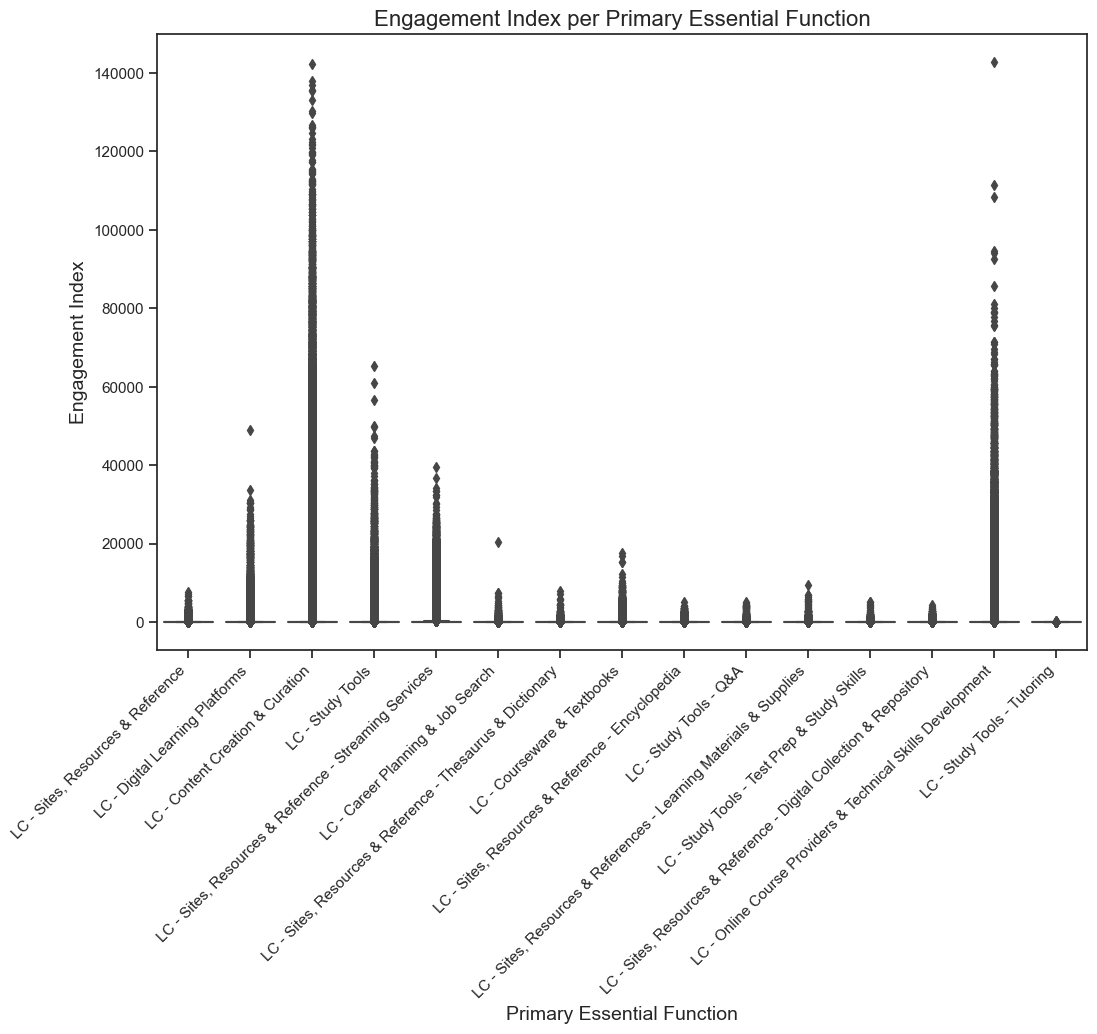

In [170]:
fig, ax = plt.subplots(figsize=(12,8))
ax = sns.boxplot(x="primary essential function", y="engagement_index", data=engagement_by_product_filtered)
ax.set_title("Engagement Index per Primary Essential Function", fontsize=16)
ax.set_xlabel("Primary Essential Function", fontsize=14)
ax.set_ylabel("Engagement Index", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.show()

From the box plot above it became clear that "LC - Content Creation & Curation" and "LC - Online Course Providers & Technical Skills Development" contains significant number of outliers. Therefore, I decided to exclute those two primary essentail funcion when calculating engagement index per state.

In [171]:
engagement_by_product_filtered = engagement_by_product_filtered[~engagement_by_product_filtered['primary essential function'].isin(['LC - Content Creation & Curation', 'LC - Online Course Providers & Technical Skills Development'])]

In [172]:
# Merge engagement and district information data
merged_data = pd.merge(engagement_by_product_filtered, district_info, on='district_id')

# Calculate average engagement level per state
avg_engagement = merged_data.groupby('state')['engagement_index'].mean().reset_index()

# Create new data frame with state and engagement_index columns
engagement_by_state = avg_engagement[['state', 'engagement_index']]
engagement_by_state['state'] = engagement_by_state['state'].str.lower()

engagement_by_state

,state,engagement_index
0,arizona,341.164569
1,california,84.155646
2,connecticut,113.396817
3,district of columbia,187.521577
4,florida,68.169898
5,illinois,122.507214
6,indiana,160.468886
7,massachusetts,103.192857
8,michigan,83.514291
9,minnesota,84.663493


Now that I have education level and engagement level by state, I'm going to investigate if there's any relationship between two variables.

In [173]:
edu_level_engagement_by_state = pd.merge(engagement_by_state, edu_level_college_or_higher, on='state', how='inner')

edu_level_engagement_by_state 


,state,engagement_index,college or higher
0,arizona,341.164569,49.40%
1,california,84.155646,56.30%
2,connecticut,113.396817,60.20%
3,district of columbia,187.521577,71.40%
4,florida,68.169898,52.80%
5,illinois,122.507214,56.90%
6,indiana,160.468886,50.00%
7,massachusetts,103.192857,60.00%
8,michigan,83.514291,53.90%
9,minnesota,84.663493,57.10%


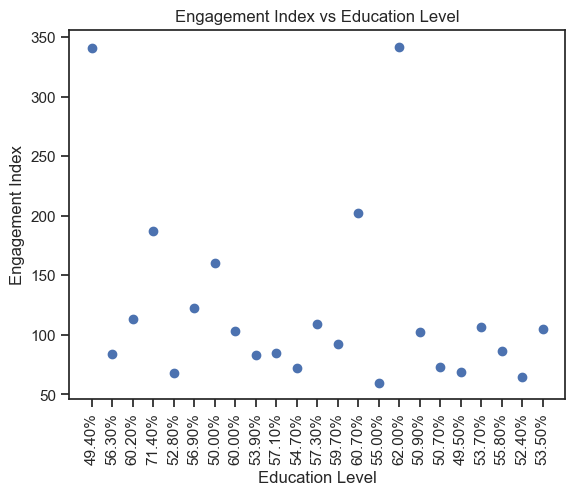

In [174]:
# Get the data
x = edu_level_engagement_by_state['college or higher']
y = edu_level_engagement_by_state['engagement_index']

# Create a scatter plot
plt.scatter(x=x, y=y)

# Add axis labels and a title
plt.xlabel('Education Level')
plt.ylabel('Engagement Index')
plt.title('Engagement Index vs Education Level')


plt.xticks(rotation=90)

# Show the plot
plt.show()


From the following scatter plot no sepecific pattern could be observed, so I decided to run regression and correlation test to see if there's any relationship between Engagement Index and Education Level

In [175]:
edu_level_engagement_by_state['college or higher'] = edu_level_engagement_by_state['college or higher'].apply(lambda x: float(x.strip('%'))/100)


Slope: 376.6105257913757
Intercept: -87.05978197237538
R-squared: 0.059516343916506974
p-value: 0.2619482876749548
Standard error: 326.69336217080127
Correlation: 0.24395971781527168


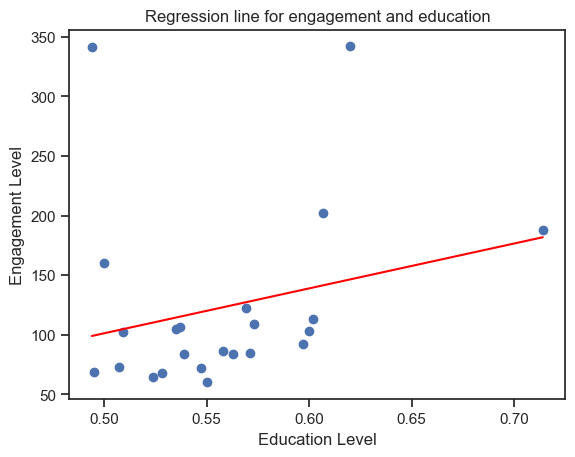

In [181]:
x = edu_level_engagement_by_state['college or higher']
y = edu_level_engagement_by_state['engagement_index']

# Perform linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

# Print the regression results
print("Slope:", slope)
print("Intercept:", intercept)
print("R-squared:", r_value**2)
print("p-value:", p_value)
print("Standard error:", std_err)

# Calculate correlation
corr = np.corrcoef(x, y)[0,1]
print("Correlation:", corr)

# Create scatter plot
plt.scatter(x, y)

# Create x values for regression line
x_reg = np.linspace(min(x), max(x), 100)

# Calculate y values for regression line
y_reg = slope * x_reg + intercept

# Add regression line to plot
plt.plot(x_reg, y_reg, color='red')

# Add title and labels
plt.title('Regression line for engagement and education')
plt.xlabel('Education Level')
plt.ylabel('Engagement Level')

# Show plot
plt.show()

The linear regression model for the data shows a positive slope of 376.61. This means that the engagement index tends to increase as the percentage of college education in a state increases.

The R-squared value of 0.059 indicates that only 5.9% of the variation in the engagement index can be explained by the variation in college education.

The p-value of 0.261 which is far greater than 0.05, meaning that there is not strong evidence to reject the null hypothesis. Therefore, there is no strong relationship between college education and engagement index.

The standard error of the slope estimate is 326.69, which indicates the variability of the slope estimate across different samples.

The correlation coefficient of 0.243 suggests that there is a weak positive correlation between college education and engagement index. This means that there is a tendency for higher levels of college education to be associated with higher levels of engagement, but the relationship is not very strong.

Overall, the analysis suggests that there is a weak positive relationship between college education and engagement index. However, the relationship is not strong enough to conclude that there is a causal relationship between the two variables. The low R-squared value and non-significant p-value indicate that there may be other factors besides college education that influence engagement index. Additionally, the wide standard error suggests that there is a fair amount of uncertainty in the slope estimate. Nonetheless, the positive slope coefficient indicates that college education may be one of several factors that contribute to higher levels of engagement index.